In [1]:
import os,sys,random,math,re,time,cv2,matplotlib

import numpy as np
import matplotlib.pyplot as plt

# Root directory of the project
ROOT_DIR = os.path.abspath("./")

# Import Mask RCNN
sys.path.append('./code')  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log

import grapes

Using TensorFlow backend.


In [2]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.

    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class InferenceConfig(grapes.GrapeConfig):
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

inference_config = InferenceConfig()

In [8]:
# Load validation set for testing

print("Loading validation set...")
dataset_val = grapes.GrapeDataset()
dataset_val.load_grape('./dataset','val')
dataset_val.prepare()
print("Done!")

Loading validation set...
Done!


In [9]:
# Import the model
# Recreate the model in inference mode
model = modellib.MaskRCNN(mode="inference",
                          config=inference_config,
                          model_dir='./')

# Get path to saved weights
# Either set a specific path or find last trained weights
model_path = os.path.join(ROOT_DIR, "mask_rcnn_grapes.h5")
#model_path = model.find_last()

# Load trained weights
print("Loading weights from ", model_path)
model.load_weights(model_path, by_name=True)

Loading weights from  C:\Users\AgelosK\Desktop\grapes-recognition\mask_rcnn_grapes.h5


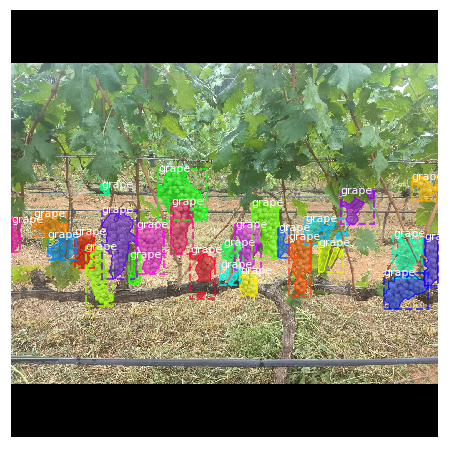

Processing 1 images
image                    shape: (1024, 1024, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 14)               min:    0.00000  max: 1024.00000  int32
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


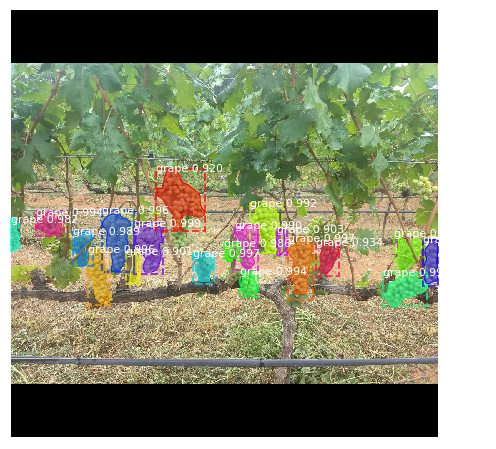

In [5]:
#The first image presents the ground truth and the second the prediction of our model

image_id = random.choice(dataset_val.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =  modellib.load_image_gt(dataset_val, inference_config,
                                                                                    image_id, use_mini_mask=False)

visualize.display_instances(original_image, gt_bbox, gt_mask, gt_class_id,
                            dataset_val.class_names, figsize=(8, 8))


results = model.detect([original_image], verbose=1)
r = results[0]

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_val.class_names, r['scores'], ax=get_ax())

In [14]:
# Compute VOC-Style mAP @ IoU=0.5
# Running on 14 images of validation set.
image_ids = np.random.choice(dataset_val.image_ids, 14)
APs = []
Prs = []
Rcs = []
for image_id in image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =  modellib.load_image_gt(dataset_val, inference_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, inference_config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    AP, precisions, recalls, overlaps = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    # Compute AP
    APs.append(AP)
    Prs.append(np.mean(precisions))
    Rcs.append(np.mean(recalls))
print("mAP:        ", np.mean(APs))
print("mPrecision: ", np.mean(Prs))
print("mRecall:    ", np.mean(Rcs))

mAP:         0.9066051454771132
mPrecision:  0.9200171735360811
mRecall:     0.5019039206763735


In [6]:
# Test your own images.

print("Loading test set...")
dataset_test = grapes.GrapeDataset()
dataset_test.load_grape('./dataset','test')
dataset_test.prepare()
print("Done!")

Loading test set...
Done!


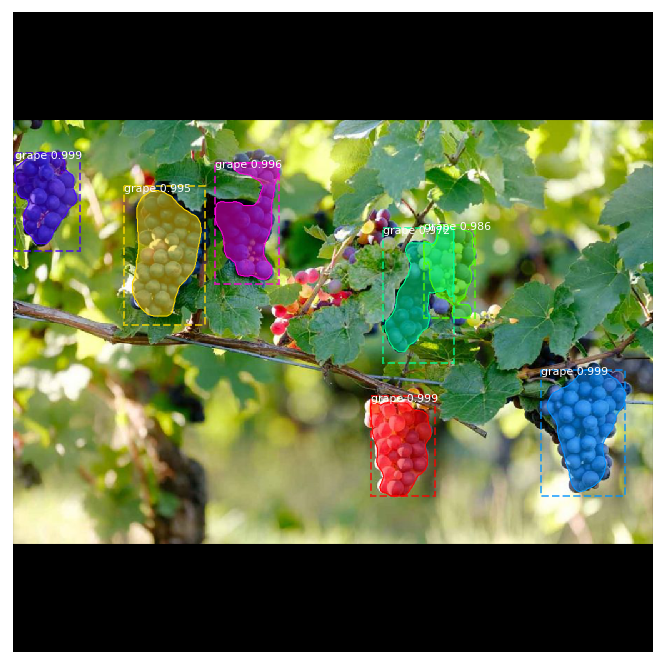

In [7]:
image_id = random.choice(dataset_test.image_ids)
original_image, image_meta, gt_class_id, gt_bbox, gt_mask =  modellib.load_image_gt(dataset_test, inference_config,
                                                                                    image_id, use_mini_mask=False)

results = model.detect([original_image], verbose=0)
r = results[0]

visualize.display_instances(original_image, r['rois'], r['masks'], r['class_ids'],
                            dataset_test.class_names, r['scores'], figsize=(12,12))